# Packages

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pprint import pprint
from prettytable import PrettyTable

In [2]:
# sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC, NuSVC
from scipy.stats import mode
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
import lightgbm as lgb
from catboost import CatBoostClassifier
import warnings 
warnings.filterwarnings("ignore")

# Initialisation

In [3]:
# Initialisation
naive_sub= pd.read_csv('forest/naive_submission.csv')
df= pd.read_csv('forest/train.csv').drop('Unnamed: 0',axis=1)
test= pd.read_csv('forest/test.csv').drop('row_ID',axis=1)

## Prétraitement des données

In [16]:
# Prétraitement des données
# Variable qualitative ou quantitative
# Toutes les variables sont quantitatives, à part Soil_Type et Wilderness_Area
columns= df.columns
quantitative_vars = columns[:10]
qual_vars = columns[10:]
qualitative_vars = [item.rsplit('_')[1] for item in qual_vars if item != 'Cover_Type']

# Filtre les données en fonction des quantiles calculés pour chaque variable
# Définition d'un nouveau dataframe df_filtered
df_filtered = df.copy()

for col in quantitative_vars:
    Q3 = df_filtered[col].quantile(0.85)
    Q1 = df_filtered[col].quantile(0.15)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
df_filtered = df_filtered.drop('Soil_Type15',axis=1)
df_filtered_long = pd.melt(df_filtered, var_name='Variables', value_name='Values')

# Feature engineering

In [17]:
df_fe = pd.DataFrame()

### Nouvelles variables

In [18]:
# Distance to hydrology
df_fe['Distance_To_Hydrology'] = np.sqrt(df_filtered['Horizontal_Distance_To_Hydrology']**2 + df_filtered['Vertical_Distance_To_Hydrology']**2)
df_fe['Distance_To_Hydrology'] = df_fe['Distance_To_Hydrology'].astype(float)

In [19]:
# Elevation to Aspect
df_fe['Elevation_Aspect'] = df_filtered['Elevation']*np.sin(np.radians(df_filtered['Aspect']))
df_fe['Elevation_Aspect'] = df_fe['Elevation_Aspect'].astype(float)

In [20]:
# Entrainement d'un modèle basé sur Soil Type et Wilderness Area

# Encode `Soil_Type` et `Wilderness_Area` comme une catégorie
soil_columns = [col for col in df_filtered.columns if col.startswith('Soil_Type')]
area_columns = [col for col in df_filtered.columns if col.startswith('Wilderness_Area')]
X_sw = df_filtered[soil_columns+area_columns]
y_sw = df_filtered['Cover_Type']

model_sw = RandomForestClassifier(random_state=42)
model_sw.fit(X_sw, y_sw)

df_fe['Soil_Wilderness_Predict'] = model_sw.predict(X_sw)
df_fe['Soil_Wilderness_Predict'] = df_fe['Soil_Wilderness_Predict'].astype(str)
df_fe['Soil_Wilderness_Predict'] = df_fe['Soil_Wilderness_Predict'].astype('category')

### Concaténation et normalisation des données

In [21]:
ct_s2 = ColumnTransformer(
    transformers=[
        ('standardize', StandardScaler(), ['Distance_To_Hydrology', 'Elevation_Aspect'])
    ],
    remainder='passthrough'
)

ct_s = ColumnTransformer(
    transformers=[
        ('standardize', StandardScaler(), quantitative_vars)
    ],
    remainder='passthrough'
)

# Normalisation
df_fe_ss = ct_s2.fit_transform(df_fe)
df_fe_ss = pd.DataFrame(df_fe_ss, columns=df_fe.columns)

df_filtered_ss = ct_s.fit_transform(df_filtered)
df_filtered_ss = pd.DataFrame(df_filtered_ss, columns=df_filtered.columns)

# Convertir en numérique les colonnes qui devraient l'être
cols_to_numeric = ['Distance_To_Hydrology', 'Elevation_Aspect']
for col in cols_to_numeric:
    df_fe_ss[col] = pd.to_numeric(df_fe_ss[col], errors='coerce')

# Convertir les autres colonnes en type "category" pour les colonnes catégorielles
cols_to_category = ['Soil_Wilderness_Predict']
for col in cols_to_category:
    df_fe_ss[col] = df_fe_ss[col].astype('category')

# Concanténation
df_filtered_ss = df_filtered_ss.join(df_fe_ss)

### Importance des nouvelles variables

In [22]:
# Creation du dataframe decoded (varaibles qualitatives ne sont plus one hot encoded)
df_fe2 = df_filtered_ss.copy()
df_fe2.columns
soil_columns = [col for col in df_fe2.columns if col.startswith('Soil_Type')]
area_columns = [col for col in df_fe2.columns if col.startswith('Wilderness_Area')]

df_fe2['Soil_Type'] = np.argmax(df_fe2[soil_columns].values, axis=1)
df_fe2['Wilderness_Area'] = np.argmax(df_fe2[area_columns].values, axis=1)

# Type catégorie pour pas confondre avec des entiers
df_fe2['Soil_Type'] = df_fe2['Soil_Type'].astype('category')
df_fe2['Wilderness_Area'] = df_fe2['Wilderness_Area'].astype('category')

# Supprimer les anciennes colonnes one-hot encodées
df_fe2 = df_fe2.drop(columns=soil_columns+area_columns)

Text(0.5, 0, 'Importance')

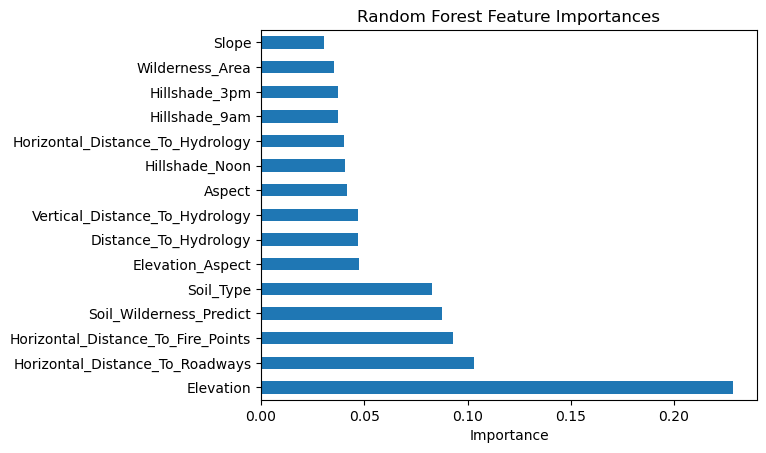

In [23]:
# Entrainer un modele de Random Forest
X_fe = df_fe2.drop('Cover_Type',axis=1)
y_fe = df_fe2['Cover_Type']

rfc_model = RandomForestClassifier()
rfc_model.fit(X_fe, y_fe)
imp = rfc_model.feature_importances_
forest_imp = pd.Series(imp, index = X_fe.columns)
forest_imp = forest_imp.sort_values(ascending=False)

# Plot les importances
fig = plt.figure()

forest_imp.plot.barh()
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')

### Fonction qui applique toutes les transformations

In [24]:
def dataframe_fe(df, model_sw, ct_s, ct_s2):
    # Input
    # model_sw : Modele pour predire Cover type a partir de Soil Type et Wilderness Area
    # ct_s : normalisation utilisé sur donnees train
    # ct_s2 : normalisation utilisé sur donnees train feature engineering

    # Output
    # df_filtered_ss: variables one hot encoded
    # df_filtered_ss: variable soil type n'est plus one hot encode

    df_fe = pd.DataFrame()
    df = df.drop('Soil_Type15', axis=1)
    
    # Distance to hydrology
    df_fe['Distance_To_Hydrology'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)
    df_fe['Distance_To_Hydrology'] = df_fe['Distance_To_Hydrology'].astype(float)

    # Elevation to Aspect
    df_fe['Elevation_Aspect'] = df['Elevation']*np.sin(np.radians(df['Aspect']))
    df_fe['Elevation_Aspect'] = df_fe['Elevation_Aspect'].astype(float)

    # Entrainement d'un modèle basé sur Soil Type et Wilderness Area
    # Encode `Soil_Type` et `Wilderness_Area` comme des catégories
    soil_columns = [col for col in df.columns if col.startswith('Soil_Type')]
    area_columns = [col for col in df.columns if col.startswith('Wilderness_Area')]
    X_sw = df[soil_columns+area_columns]

    df_fe['Soil_Wilderness_Predict'] = model_sw.predict(X_sw)
    df_fe['Soil_Wilderness_Predict'] = df_fe['Soil_Wilderness_Predict'].astype(str)
    df_fe['Soil_Wilderness_Predict'] = df_fe['Soil_Wilderness_Predict'].astype('category')

    # Normalisation
    df_fe_ss = ct_s2.fit_transform(df_fe)
    df_fe_ss = pd.DataFrame(df_fe_ss, columns=df_fe.columns)

    # Convertir en numérique les colonnes qui devraient l'être
    cols_to_numeric = ['Distance_To_Hydrology', 'Elevation_Aspect']
    for col in cols_to_numeric:
        df_fe_ss[col] = pd.to_numeric(df_fe_ss[col], errors='coerce')

    # Convertir les autres colonnes en type "category" pour les colonnes catégorielles
    cols_to_category = ['Soil_Wilderness_Predict']
    for col in cols_to_category:
        df_fe_ss[col] = df_fe_ss[col].astype('category')

    # Transformé les données
    df_filtered_ss = ct_s.fit_transform(df)
    df_filtered_ss = pd.DataFrame(df_filtered_ss, columns=df.columns)
    df_filtered_ss = df_filtered_ss.join(df_fe_ss)

    ### Données pour laquelle la variable Soil_Type est décodée ###
    df_filtered_ss2 = df_filtered_ss.copy()

    soil_columns = [col for col in df_filtered_ss2.columns if col.startswith('Soil_Type')]

    df_filtered_ss2['Soil_Type'] = np.argmax(df_filtered_ss2[soil_columns].values, axis=1)

    # Type catégorie pour pas confondre avec des entiers
    df_filtered_ss2['Soil_Type'] = df_filtered_ss2['Soil_Type'].astype('category')

    # Supprimer les anciennes colonnes one-hot encodées
    df_filtered_ss2 = df_filtered_ss2.drop(columns=soil_columns)

    return df_filtered_ss, df_filtered_ss2